# <a href="http://www.redditscore.com">![redditscore](https://s3.us-east-2.amazonaws.com/redditscore/logo.png)</a> 
***A machine learning approach to predicting how badly you'll get roasted for your sub-par reddit comments.***

Alex Hartford & Trevor Hacker

### **Dataset**

Reddit comments from September, 2018 (<a href="http://files.pushshift.io/reddit/">source</a>).  This is well over 100gb of data.  We will likely only use a subset of the data but will ultimately try to use the entire dataset.

### **Objectives**

Create a linear regression model to predict the reddit score of a comment a user is considering posting. 

Stretch goal - narrow comment scoring down by subreddit, as comment popularity will differ between reddit communities.

Allow users to use this model with a publicly available <a href="http://www.redditscore.com">Website</a>.

Open source the project to allow further contributions if anyone is interested.

## Formal Hypothesis and Data Analysis

By analyzing comments made on the Reddit platform by prior users, we believe that people who seek to gather as much reputation as possible on Reddit would find value in being able to predict whether their comments will be well received by the community.  In the process, finding some of the most common highly/negatively received comments would be very interesting information as it can provide insight into the current trends of the web.

This dataset is just one of many - there are datasets for all the information ever posted on Reddit, publicly available for use. Community members of Reddit have assembled the data by running scripts on the Reddit API and did most of the cleaning for us. Interestingly, people released these datasets in hope that people would create something out of them - quite awhile ago. From what I can tell, Redditscore is one of the first applications that uses this data, rather than just providing a few nice graphs.  There is actually a problem potentially being solved here, as there are people who live for Reddit karma.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print('Libraries loaded!')

Libraries loaded!


## Import and Clean Data

In [2]:
print('Loading memes...')

# df = pd.read_csv('https://s3.us-east-2.amazonaws.com/redditscore/2500rows.csv')
df = pd.read_csv('https://s3.us-east-2.amazonaws.com/redditscore/2mrows.csv', error_bad_lines=False, engine='python', encoding='utf-8')

print('Memes are fully operational!')

Loading memes...


Skipping line 68: ',' expected after '"'
Skipping line 155: ',' expected after '"'
Skipping line 180: ',' expected after '"'
Skipping line 186: ',' expected after '"'
Skipping line 1998: ',' expected after '"'
Skipping line 2028: ',' expected after '"'
Skipping line 2092: ',' expected after '"'
Skipping line 2540: ',' expected after '"'
Skipping line 2874: ',' expected after '"'
Skipping line 3642: ',' expected after '"'
Skipping line 4327: ',' expected after '"'
Skipping line 4383: ',' expected after '"'
Skipping line 4398: ',' expected after '"'
Skipping line 4535: ',' expected after '"'
Skipping line 5348: ',' expected after '"'
Skipping line 5745: ',' expected after '"'
Skipping line 6077: ',' expected after '"'
Skipping line 6416: ',' expected after '"'
Skipping line 6574: ',' expected after '"'
Skipping line 6954: ',' expected after '"'
Skipping line 7543: ',' expected after '"'
Skipping line 7709: ',' expected after '"'
Skipping line 8476: ',' expected after '"'
Skipping line 85

Skipping line 141894: ',' expected after '"'
Skipping line 142003: ',' expected after '"'
Skipping line 142085: ',' expected after '"'
Skipping line 142234: ',' expected after '"'
Skipping line 142450: ',' expected after '"'
Skipping line 142633: ',' expected after '"'
Skipping line 142693: ',' expected after '"'
Skipping line 142708: ',' expected after '"'
Skipping line 142839: ',' expected after '"'
Skipping line 142976: ',' expected after '"'
Skipping line 143199: ',' expected after '"'
Skipping line 143711: ',' expected after '"'
Skipping line 144549: ',' expected after '"'
Skipping line 145119: ',' expected after '"'
Skipping line 145469: ',' expected after '"'
Skipping line 145755: ',' expected after '"'
Skipping line 145768: ',' expected after '"'
Skipping line 145808: ',' expected after '"'
Skipping line 145878: ',' expected after '"'
Skipping line 146233: ',' expected after '"'
Skipping line 146343: ',' expected after '"'
Skipping line 146979: ',' expected after '"'
Skipping l

Skipping line 555076: ',' expected after '"'
Skipping line 555436: ',' expected after '"'
Skipping line 555455: ',' expected after '"'
Skipping line 555627: ',' expected after '"'
Skipping line 556076: ',' expected after '"'
Skipping line 556993: ',' expected after '"'
Skipping line 557120: ',' expected after '"'
Skipping line 557355: ',' expected after '"'
Skipping line 557438: ',' expected after '"'
Skipping line 558336: ',' expected after '"'
Skipping line 558442: ',' expected after '"'
Skipping line 558615: ',' expected after '"'
Skipping line 558984: ',' expected after '"'
Skipping line 559018: ',' expected after '"'
Skipping line 559168: ',' expected after '"'
Skipping line 559736: ',' expected after '"'
Skipping line 560379: ',' expected after '"'
Skipping line 560785: ',' expected after '"'
Skipping line 560873: ',' expected after '"'
Skipping line 561376: ',' expected after '"'
Skipping line 561971: ',' expected after '"'
Skipping line 562486: ',' expected after '"'
Skipping l

Skipping line 621270: ',' expected after '"'
Skipping line 621392: ',' expected after '"'
Skipping line 621562: ',' expected after '"'
Skipping line 621910: ',' expected after '"'
Skipping line 621971: ',' expected after '"'
Skipping line 622078: ',' expected after '"'
Skipping line 622386: ',' expected after '"'
Skipping line 622601: ',' expected after '"'
Skipping line 623761: ',' expected after '"'
Skipping line 623840: ',' expected after '"'
Skipping line 624853: ',' expected after '"'
Skipping line 624975: ',' expected after '"'
Skipping line 625021: ',' expected after '"'
Skipping line 625555: ',' expected after '"'
Skipping line 625572: ',' expected after '"'
Skipping line 625830: ',' expected after '"'
Skipping line 625862: ',' expected after '"'
Skipping line 625913: ',' expected after '"'
Skipping line 625921: ',' expected after '"'
Skipping line 626378: ',' expected after '"'
Skipping line 626747: ',' expected after '"'
Skipping line 627188: ',' expected after '"'
Skipping l

Skipping line 923415: ',' expected after '"'
Skipping line 923931: ',' expected after '"'
Skipping line 924028: ',' expected after '"'
Skipping line 924592: ',' expected after '"'
Skipping line 924711: ',' expected after '"'
Skipping line 925113: ',' expected after '"'
Skipping line 925275: ',' expected after '"'
Skipping line 925354: ',' expected after '"'
Skipping line 926078: ',' expected after '"'
Skipping line 926423: ',' expected after '"'
Skipping line 926512: ',' expected after '"'
Skipping line 926516: ',' expected after '"'
Skipping line 926731: ',' expected after '"'
Skipping line 926890: ',' expected after '"'
Skipping line 927410: ',' expected after '"'
Skipping line 927735: ',' expected after '"'
Skipping line 927871: ',' expected after '"'
Skipping line 927908: ',' expected after '"'
Skipping line 927954: ',' expected after '"'
Skipping line 928513: ',' expected after '"'
Skipping line 929753: ',' expected after '"'
Skipping line 929979: ',' expected after '"'
Skipping l

Skipping line 1227950: ',' expected after '"'
Skipping line 1228004: ',' expected after '"'
Skipping line 1228209: ',' expected after '"'
Skipping line 1228348: ',' expected after '"'
Skipping line 1228838: ',' expected after '"'
Skipping line 1229078: ',' expected after '"'
Skipping line 1229352: ',' expected after '"'
Skipping line 1229969: ',' expected after '"'
Skipping line 1230328: ',' expected after '"'
Skipping line 1230846: ',' expected after '"'
Skipping line 1232424: ',' expected after '"'
Skipping line 1232466: ',' expected after '"'
Skipping line 1232506: ',' expected after '"'
Skipping line 1232627: ',' expected after '"'
Skipping line 1232695: ',' expected after '"'
Skipping line 1232698: ',' expected after '"'
Skipping line 1232774: ',' expected after '"'
Skipping line 1232922: ',' expected after '"'
Skipping line 1233036: ',' expected after '"'
Skipping line 1233375: ',' expected after '"'
Skipping line 1233403: ',' expected after '"'
Skipping line 1234099: ',' expecte

Skipping line 1358641: ',' expected after '"'
Skipping line 1358692: ',' expected after '"'
Skipping line 1358741: ',' expected after '"'
Skipping line 1358808: ',' expected after '"'
Skipping line 1359156: ',' expected after '"'
Skipping line 1359200: ',' expected after '"'
Skipping line 1359325: ',' expected after '"'
Skipping line 1359413: ',' expected after '"'
Skipping line 1360212: ',' expected after '"'
Skipping line 1360927: ',' expected after '"'
Skipping line 1361386: ',' expected after '"'
Skipping line 1361476: ',' expected after '"'
Skipping line 1361520: ',' expected after '"'
Skipping line 1362380: ',' expected after '"'
Skipping line 1362463: ',' expected after '"'
Skipping line 1362661: ',' expected after '"'
Skipping line 1362783: ',' expected after '"'
Skipping line 1363004: ',' expected after '"'
Skipping line 1364779: ',' expected after '"'
Skipping line 1365638: ',' expected after '"'
Skipping line 1366198: ',' expected after '"'
Skipping line 1366446: ',' expecte

Skipping line 1536328: ',' expected after '"'
Skipping line 1536401: ',' expected after '"'
Skipping line 1536465: ',' expected after '"'
Skipping line 1536523: ',' expected after '"'
Skipping line 1536906: ',' expected after '"'
Skipping line 1537049: ',' expected after '"'
Skipping line 1537085: ',' expected after '"'
Skipping line 1537559: ',' expected after '"'
Skipping line 1537798: ',' expected after '"'
Skipping line 1537895: ',' expected after '"'
Skipping line 1538058: ',' expected after '"'
Skipping line 1538207: ',' expected after '"'
Skipping line 1538415: ',' expected after '"'
Skipping line 1538464: ',' expected after '"'
Skipping line 1538944: ',' expected after '"'
Skipping line 1539084: ',' expected after '"'
Skipping line 1539162: ',' expected after '"'
Skipping line 1539256: ',' expected after '"'
Skipping line 1539921: ',' expected after '"'
Skipping line 1539951: ',' expected after '"'
Skipping line 1540069: ',' expected after '"'
Skipping line 1540292: ',' expecte

Skipping line 1628931: ',' expected after '"'
Skipping line 1629218: ',' expected after '"'
Skipping line 1629703: ',' expected after '"'
Skipping line 1629968: ',' expected after '"'
Skipping line 1630451: ',' expected after '"'
Skipping line 1630546: ',' expected after '"'
Skipping line 1630845: ',' expected after '"'
Skipping line 1631614: ',' expected after '"'
Skipping line 1632018: ',' expected after '"'
Skipping line 1632225: ',' expected after '"'
Skipping line 1632710: ',' expected after '"'
Skipping line 1633003: ',' expected after '"'
Skipping line 1633274: ',' expected after '"'
Skipping line 1633501: ',' expected after '"'
Skipping line 1633762: ',' expected after '"'
Skipping line 1633821: ',' expected after '"'
Skipping line 1634422: ',' expected after '"'
Skipping line 1634510: ',' expected after '"'
Skipping line 1634642: ',' expected after '"'
Skipping line 1635105: ',' expected after '"'
Skipping line 1635436: ',' expected after '"'
Skipping line 1635663: ',' expecte

Skipping line 1887442: ',' expected after '"'
Skipping line 1887881: ',' expected after '"'
Skipping line 1887961: ',' expected after '"'
Skipping line 1888388: ',' expected after '"'
Skipping line 1888606: ',' expected after '"'
Skipping line 1888694: ',' expected after '"'
Skipping line 1889060: ',' expected after '"'
Skipping line 1889435: ',' expected after '"'
Skipping line 1890013: ',' expected after '"'
Skipping line 1890368: ',' expected after '"'
Skipping line 1890611: ',' expected after '"'
Skipping line 1890709: ',' expected after '"'
Skipping line 1890908: ',' expected after '"'
Skipping line 1890924: ',' expected after '"'
Skipping line 1891140: ',' expected after '"'
Skipping line 1891828: ',' expected after '"'
Skipping line 1892594: ',' expected after '"'
Skipping line 1892955: ',' expected after '"'
Skipping line 1893609: ',' expected after '"'
Skipping line 1894532: ',' expected after '"'
Skipping line 1894859: ',' expected after '"'
Skipping line 1895032: ',' expecte

Memes are fully operational!


In [3]:
print(df.dtypes)
print()
print(df.shape)
df.head(10)

subreddit     object
body          object
score        float64
dtype: object

(1961645, 3)


,subreddit,body,score
0,LabVIEW,Seconding this Ive used it on some pretty larg...,1.0
1,Bitcoin,I am not in debt and I shall rise again to inv...,0.0
2,worldnews,So that thin crowd was actually Russians? I wa...,7.0
3,AteTheOnion,[deleted],8.0
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5.0
5,anime_irl,You can just tell that he's trying not to say ...,1.0
6,NintendoSwitch,Get Zelda,86.0
7,AskEconomics,[removed],2.0
8,mexico,[removed],1.0
9,nottheonion,Nobody likes a lingerer,2.0


The score will always be an integer since it is based on upvotes and downvotes. Before converting however, we need to check if there are any null values.

In [4]:
df.isna().sum()

subreddit        1
body         16713
score        20539
dtype: int64

In [5]:
df[df.isnull().any(axis=1)].head(20)

,subreddit,body,score
239,AskRedditUL,/u/lifeandtimes89,NaN
240,Your post,None,NaN
241,&gt;Redditors I want to here your hero storie...,None,NaN
242,was mentioned since it was deleted by the res...,None,NaN
243,If you would like to submit your question aga...,None,NaN
244,Feel free to submit your question here on /r/...,None,NaN
245,**Subscribe to this subreddit for more unrest...,1,NaN
805,TrumpPA,I've taken the liberty of creating an archive ...,NaN
806,(If you would like to support Philly.com fina...,2,NaN
829,lego_raffles,Raffle [Announcement](/r/lego_raffles/comments...,NaN


There is only a small amount of null values and they appear to be of little use, so removing them seems to be the best bet. Once the null values are removed we can convert score to an integer.

In [6]:
df = df.dropna()
df['score'] = df['score'].astype('int')

In [7]:
print(df.shape)
df.head(10)

(1941086, 3)


,subreddit,body,score
0,LabVIEW,Seconding this Ive used it on some pretty larg...,1
1,Bitcoin,I am not in debt and I shall rise again to inv...,0
2,worldnews,So that thin crowd was actually Russians? I wa...,7
3,AteTheOnion,[deleted],8
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5
5,anime_irl,You can just tell that he's trying not to say ...,1
6,NintendoSwitch,Get Zelda,86
7,AskEconomics,[removed],2
8,mexico,[removed],1
9,nottheonion,Nobody likes a lingerer,2


## Initial Data Analysis

Before getting into handling the comment body a better understanding of the score collumn needs to be gained.

In [8]:
df['score'].describe()

count    1.941086e+06
mean     9.131036e+00
std      1.158268e+02
min     -4.717000e+03
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      3.920900e+04
Name: score, dtype: float64

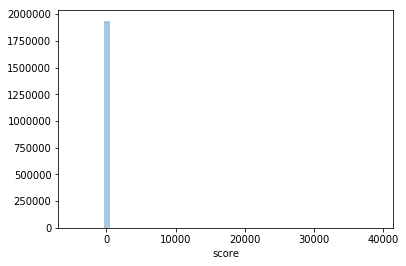

In [9]:
sns.distplot(df["score"], kde=False)

As seen standard deviation and the distribution plot, there is a large distribution of data which makes the dataset skewed.

In order to solve this log sclaling can be applied which might be useful later on.

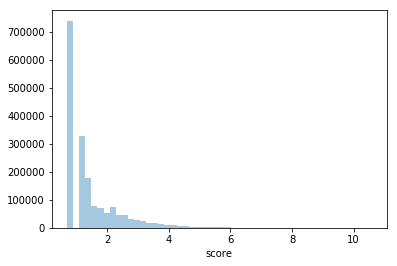

In [10]:
mask = df["score"] > 0
sns.distplot(np.log1p(df["score"][mask]), kde=False)

The positive scores appear to be skewed with a significant majority of values being equal to 1. 

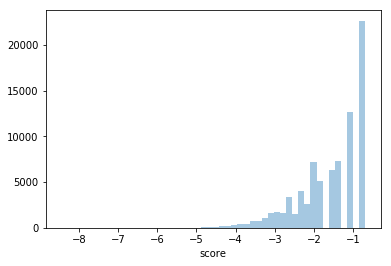

In [11]:
mask = df["score"] < 0
sns.distplot(-np.log1p(-df["score"][mask]), kde=False)

The negative scores also seem a little skewed.

#### Adding another score column

In order to understand the data better and also create a logistic regression model a seperate column was created with the values of positive, negative or one score. Positive score being anything greater than 1, negative being anything less than 1 and one being 1. The reason for this classification is how comments on reddit work, since whenever a comment is made it automatically gets an upvote and therfore if the score is zero it got a downvote.

In [12]:
df['pn_score'] = ""

for i in df['score'].index:
    if  df['score'].at[i] > 1:
        df['pn_score'].at[i] = 'positive'
    elif float(df['score'].at[i]) <= 0:
        df['pn_score'].at[i] = 'negative'
    else:
        df['pn_score'].at[i] = 'one'  

df.head(10)

,subreddit,body,score,pn_score
0,LabVIEW,Seconding this Ive used it on some pretty larg...,1,one
1,Bitcoin,I am not in debt and I shall rise again to inv...,0,negative
2,worldnews,So that thin crowd was actually Russians? I wa...,7,positive
3,AteTheOnion,[deleted],8,positive
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5,positive
5,anime_irl,You can just tell that he's trying not to say ...,1,one
6,NintendoSwitch,Get Zelda,86,positive
7,AskEconomics,[removed],2,positive
8,mexico,[removed],1,one
9,nottheonion,Nobody likes a lingerer,2,positive


positive    1053684
one          739088
negative     148314
Name: pn_score, dtype: int64


Text(0,0.5,'Number of Samples')

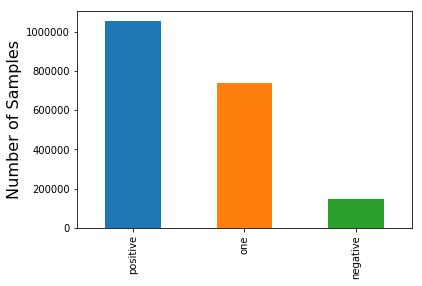

In [13]:
pn_counts = df['pn_score'].value_counts()
print(pn_counts)
pn_counts.plot.bar()
plt.ylabel("Number of Samples", fontsize=16)

Again there is an issue with distribution here. The majority of dataset has positive score values, where negative scores are much less frequent.

## Logistic Regression Model
There will be a combination of logistic regression and linear regression models used.

The logistic model will be created based on the categorical score values, so it will predict whether the comment will have a postive or negative score or a score of 1.  

In order for the comments to be meaningful predictors of score they first need to be turned into a vector of numerical features. The vectorizer used implements Text Frequency-Inverse Document Frequency (TfIdf) weighting. Additionally stop_words were removed from the vector.

In [14]:
log_vect = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True, stop_words='english')
text_features = log_vect.fit_transform(df.body)
print(text_features.shape)

(1941086, 101474)


In [15]:
list(log_vect.vocabulary_)[:10]

['seconding',
 'ive',
 'used',
 'pretty',
 'large',
 'data',
 'sets',
 'issue',
 'debt',
 'shall']

In [16]:
encoder = LabelEncoder()
numerical_labels = encoder.fit_transform(df['pn_score'])

training_X, testing_X, training_y, testing_y = train_test_split(text_features,
                                                               numerical_labels,
                                                               stratify=numerical_labels)
print(training_y)

logistic_regression = SGDClassifier(loss="log", penalty="l2", max_iter=250)
logistic_regression.fit(training_X, training_y)
pred_labels = logistic_regression.predict(testing_X)

accuracy = accuracy_score(testing_y, pred_labels)
cm = confusion_matrix(testing_y, pred_labels)

print("Accuracy:", accuracy)
print("Classes:", str(encoder.classes_))
print("Confusion Matrix:")
print(cm)

[2 2 2 ... 0 0 1]
Accuracy: 0.5961028042005309
Classes: ['negative' 'one' 'positive']
Confusion Matrix:
[[     0   5712  31367]
 [     0  37538 147234]
 [     0  11687 251734]]


Since the data is so skewed a simple random over-sampling was used in order to increase the number of negative scores. The reason for using over-sampling as opposed to under-sampling is because we didn't want to loose any comments that could contribute as predictors. This does run the risk of overfitting the data however.

Random over-sampling:
positive    1053684
one          739088
negative     739088
Name: pn_score, dtype: int64


Text(0,0.5,'Number of Samples')

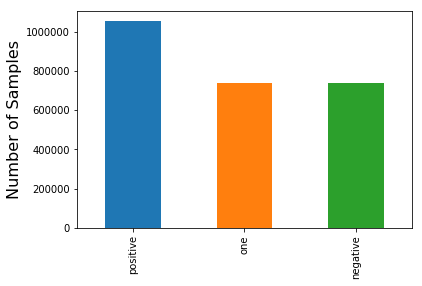

In [17]:
count_pos, count_one, count_neg = df['pn_score'].value_counts()

df_pos_score = df[df['pn_score'] == 'positive']
df_neg_score = df[df['pn_score'] == 'negative']
df_one_score = df[df['pn_score'] == 'one']

df_neg_score_over = df_neg_score.sample(count_one, replace=True)
df_score_over = pd.concat([df_pos_score, df_neg_score_over, df_one_score], axis=0)

print('Random over-sampling:')

pn_counts = df_score_over['pn_score'].value_counts()
print(pn_counts)
pn_counts.plot.bar()
plt.ylabel("Number of Samples", fontsize=16)

Similarily to first model the comments need to be vectorized.

In [18]:
log_vect_over = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True, stop_words='english')
text_features = log_vect_over.fit_transform(df_score_over.body)
print(text_features.shape)

(2531860, 128094)


In [19]:
list(log_vect_over.vocabulary_)[:10]

['crowd',
 'actually',
 'russians',
 'joking',
 'joke',
 'turns',
 'deleted',
 'hope',
 'ran',
 'away']

Now that the comments are turned into vectorized features they can be used in the logistic regression model. In order to achieve better results the random over-sampled data is used.

In [20]:
encoder = LabelEncoder()
numerical_labels = encoder.fit_transform(df_score_over['pn_score'])

training_X, testing_X, training_y, testing_y = train_test_split(text_features,
                                                               numerical_labels,
                                                               stratify=numerical_labels)
print(training_y)

logistic_regression_over = SGDClassifier(loss="log", penalty="l2", max_iter=1500)
logistic_regression_over.fit(training_X, training_y)
pred_labels = logistic_regression_over.predict(testing_X)

accuracy = accuracy_score(testing_y, pred_labels)
cm = confusion_matrix(testing_y, pred_labels)

print("Accuracy:", accuracy)
print("Classes:", str(encoder.classes_))
print("Confusion Matrix:")
print(cm)

[2 1 1 ... 0 2 0]
Accuracy: 0.4774545196021897
Classes: ['negative' 'one' 'positive']
Confusion Matrix:
[[ 33626  10591 140555]
 [ 16730  25612 142430]
 [ 13682   6765 242974]]


According to the confusion matrix the model struggles with determining a comment that has a score of 1 and usually mistakes it for a positive comment. It seems to perform the best with negative comments which could indicate overfitting of the data.

## Linear Regression Models

There will be two linear regression models, one for detecting the value of the positive score comments and another for detective the value of the negative score comments. The specific one will be used depending on the outcome of the logistic regression model.

### Positive Scores

The first linear regression model will predict that of the postive score. In order to do that only the rows with a positive score are necessary.

In [21]:
pos_score_df = df[df.pn_score == 'positive']

pos_score_df.head()

,subreddit,body,score,pn_score
2,worldnews,So that thin crowd was actually Russians? I wa...,7,positive
3,AteTheOnion,[deleted],8,positive
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5,positive
6,NintendoSwitch,Get Zelda,86,positive
7,AskEconomics,[removed],2,positive


Similarily to the logistic regression the comments need to be transformed into a vector of numerical values.

In [22]:
pos_vect = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True, stop_words='english')
text_features = pos_vect.fit_transform(pos_score_df.body)
print(text_features.shape)

(1053684, 74485)


In [23]:
list(pos_vect.vocabulary_)[:10]

['crowd',
 'actually',
 'russians',
 'joking',
 'joke',
 'turns',
 'deleted',
 'hope',
 'ran',
 'away']

Now that the comments are vectorized, the model can be created. In order to eliminate the issue with large distribution noticed during the alaysis, the scores are log scaled.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(text_features, np.log1p(pos_score_df['score']))

pos_linear_regression = SGDRegressor(max_iter=1500)
pos_linear_regression.fit(X_train, y_train)
test = pos_linear_regression.predict(X_test)
mse = mean_squared_error(y_test, test)
rmse = np.sqrt(mse)
print()
print("Positive Score Model MSE:", mse)
print("Positive Score Model RMSE:", rmse)


Positive Score Model MSE: 0.8749582956086429
Positive Score Model RMSE: 0.935392054493004


Based on the rmse the model seems to preform pretty well.

### Negative Scores

The second linear regression model will predict the negative scores. Similarily to the first model only the rows with negative scores are necessary and the comment need to be vectorized using those.

In [25]:
neg_score_df = df[df.pn_score == 'negative']

neg_score_df.head()

,subreddit,body,score,pn_score
1,Bitcoin,I am not in debt and I shall rise again to inv...,0,negative
14,ireland,"Interesting but ""re-legalised"" is the wrong te...",0,negative
15,nfl,Defense won't win you championships anymore. I...,-8,negative
27,CFB,You must have X-ray vision to be able to see t...,0,negative
30,IdiotsInCars,I came here to say this! Regardless of opinion...,-18,negative


In [26]:
neg_vect = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True, stop_words='english')
text_features = neg_vect.fit_transform(neg_score_df.body)
print(text_features.shape)

(148314, 22404)


In [27]:
list(neg_vect.vocabulary_)[:10]

['debt',
 'shall',
 'rise',
 'invest',
 'stocks',
 'god',
 'willing',
 'interesting',
 'wrong',
 'term']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(text_features, -np.log1p(-neg_score_df["score"]))

neg_linear_regression = SGDRegressor(max_iter=1500)
neg_linear_regression.fit(X_train, y_train)
test = neg_linear_regression.predict(X_test)
mse = mean_squared_error(y_test, test)
rmse = np.sqrt(mse)
print()
print("Negative Score Model MSE:", mse)
print("Negative Score Model RMSE:", rmse)


Negative Score Model MSE: 1.0130192799066775
Negative Score Model RMSE: 1.0064885890593482


The results are similar to the first model.

## Combining Models

First the logistic regression model will be used to preditc whether or not the score is negative or positive, then depending on the outcome the appropriate linear regression model will be used to predict the score value

In [29]:
a = (["You sir a simple idiot. Or a Russian bot. Either way not worth an actual sentence on why I didn't vote for that loon."])

logistic_result = logistic_regression_over.predict(log_vect_over.transform(a))
print('Logistic Result: ')
print(logistic_result)
print()

if(logistic_result) == 2:
    linear_result = pos_linear_regression.predict(pos_vect.transform(a))
    print('Linear Result: ')
    print(linear_result)
elif(logistic_result) == 0:
    linear_result = neg_linear_regression.predict(neg_vect.transform(a))
    print('Linear Result: ')
    print(linear_result)

Logistic Result: 
[0]

Linear Result: 
[-1.09910057]


Lastly, we want to pickle our models and vectorizers for deployment.

In [30]:
import pickle
pickle.dump(logistic_regression_over, open('logreg.pkl', 'wb'))
pickle.dump(pos_linear_regression, open('poslinreg.pkl', 'wb'))
pickle.dump(neg_linear_regression, open('neglinreg.pkl', 'wb'))
pickle.dump(log_vect_over, open('log_vect.pkl', 'wb'))
pickle.dump(pos_vect, open('pos_vect.pkl', 'wb'))
pickle.dump(neg_vect, open('neg_vect.pkl', 'wb'))

## **Conclusion**

We did a fair job of proving our hypothesis.  We found that due to the large volume of comments that go relatively unseen,
a model isn't going to be able to predict any huge scores.  However, it does a really nice job of pointing you in the right
direction as it can properly determine if the comment will be received positively or negatively, and does give a range,
usually between -10 and 10.  This is enough to let a commenter know what to expect from their comment.

Our analysis could be improved by including the subreddit as a category.  Reddit is a large community, with many subcommunities.
These subcommunities often have a completely different audience from one another, so it's important to distinguish what may be
received positively by one community may be received very negatively by another.  I'm sure there are also other factors that could
be added in that would help improve the model as the dataset is quite extensive, and we decided just to focus on what we considered
the strongest predictor.

A lesson learned was to really know the data you are working with.  We were struggling to get varying values for a long time,
having most scores range around 1.  Suddenly, it hit us... Reddit comments have a score of 1 by default as the poster automatically
upvotes their own comment.  Therefore, using zero to categorize comments that saw no attention was leaving all the 1 values in,
which led to them dominating the prediction of positive scores.  By instead counting 0 as a negative, as someone would have to
downvote a comment for it to have a 0, and 1 as the neutral value, our model became exponentially more predictive.  It was the
very definition of a lightbulb moment, and if we had saw this earlier it could have given us more time to spend in other areas.

Having the freedom to work on a dataset of our choice is a really great way to end a course as it gives you an application of what
you spent the term learning.  So often that is missed, you complete a course and you don't apply the material and therefore it's lost.
This was a great opportunity to apply our new skills to a domain we found very interesting.